# K Means

![Logo Tec](img/LogoTec2.jpg)

## Ciencia y analítica de datos (Gpo 10)
### Alumno: Armando Bringas Corpus (A01200230)
### Profesores: Dra. María de la Paz Rico Fernández, Mtra. Victoria Guerrero Orozco
### Fecha: 9 de noviembre de 2022

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [1]:
# ! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context ='notebook', ticks =True, grid =False) 

In [3]:
import geopandas as gpd
from geopy.distance import geodesic as GD
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import qeds
qeds.themes.mpl_style();
from tqdm import tqdm

Importa la base de datos

In [4]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [5]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [7]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

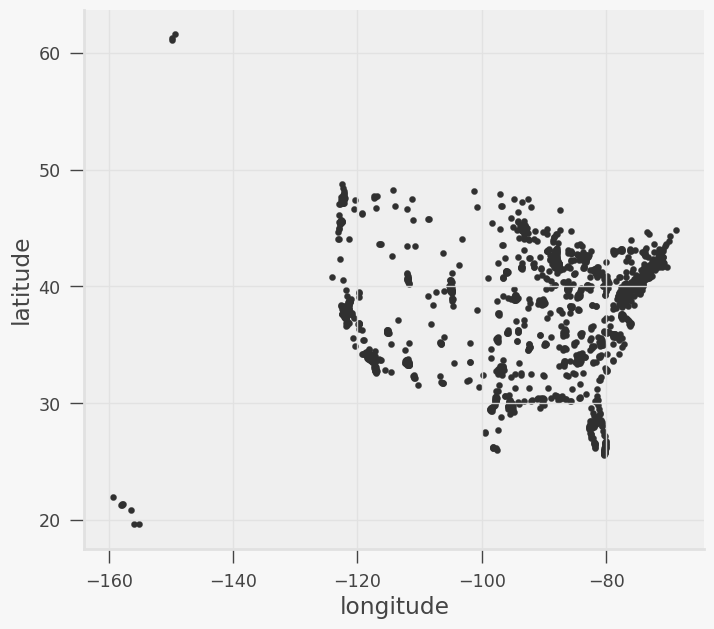

In [8]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [9]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [10]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [11]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [12]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,889953.0,Oceania,Fiji,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,58005463.0,Africa,Tanzania,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253.0,Africa,W. Sahara,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,37589262.0,North America,Canada,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,328239523.0,North America,United States of America,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [13]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

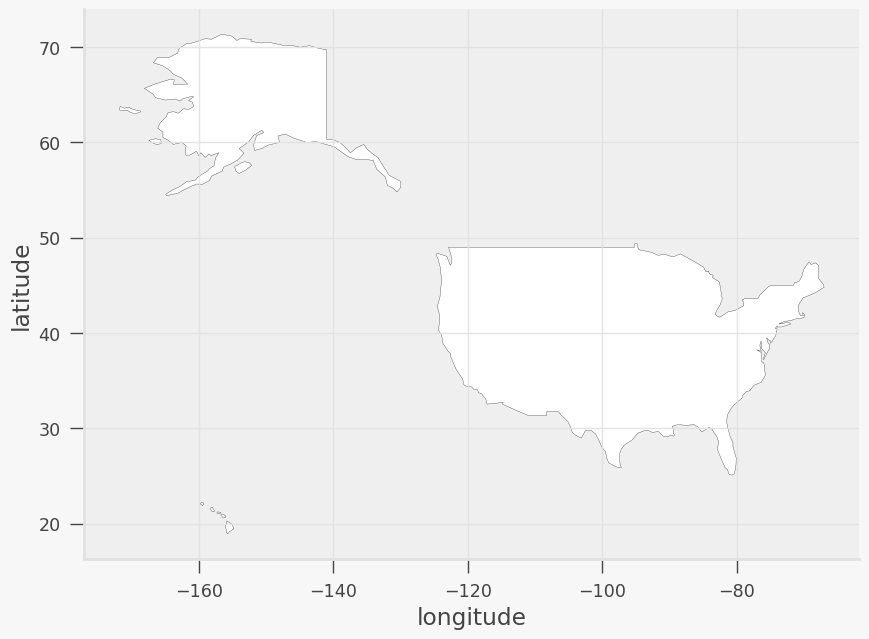

In [14]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

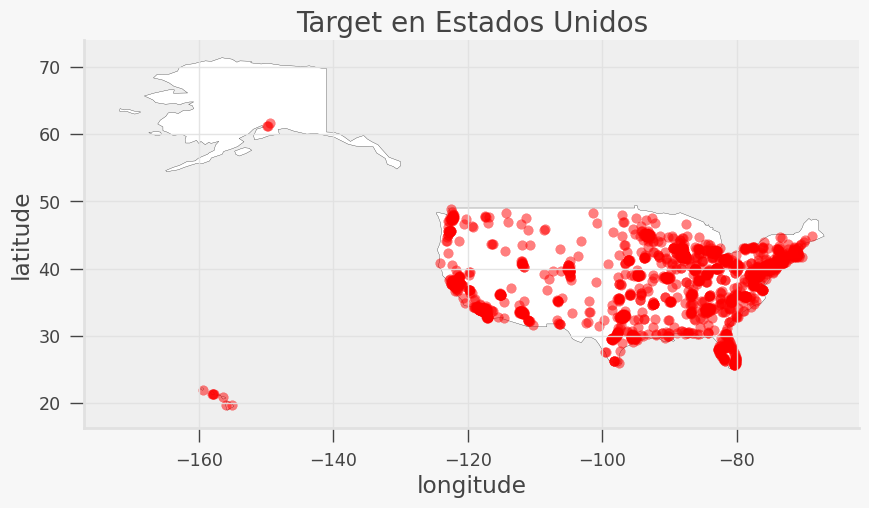

In [15]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

# Desarrollo de la Actividad

### Declaración de Funciones para la graficación de las localizaciones de los almacenes

In [16]:
def plot_clusters(X, y_pred, k):
    if k == 3:
        assign_classes=['Cluster 1', 'Cluster 2', 'Cluster 3']
        colors = ListedColormap(['r','b','g'])
    elif k == 5:
        assign_classes=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
        colors = ListedColormap(['r','g','b','yellow','m'])
    
    scatter = plt.scatter(
        df.loc[:, ['longitude']], df.loc[:, ['latitude']],
        c=y_pred, cmap=colors, s=50)
    plt.legend(handles=scatter.legend_elements()[0], labels=assign_classes, fontsize=15)
    plt.title('Warehouse Location', fontsize=25)
    plt.xlabel("latitude")
    plt.ylabel("longitude")

def plot_centroids(centroids, circle_color='w', cross_color='k'):
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=100, linewidths=4,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=70, linewidths=4,
                color=cross_color, zorder=10, alpha=0.9)

def plot_map(X, y_pred, k, centroids):
    fig, gax = plt.subplots()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')
    plot_clusters(X, y_pred, k)
    plot_centroids(centroids)
    plt.gca().set_axisbelow(True)
    plt.show()

## Elección del Número de Almacenes

*¿Cómo elegiste el numero de almacenes?, justifica tu respuesta tecnicamente.*

Para poder utilizar el algoritmo de K-means para obtener los clústers, primero necesitamos determinar el número de agrupaciones, para este caso decidimos utilizar el ***Método de Curva de Codo ('Elbow curve method')***. En el cual se ejecuta el algoritmo K-means estableciendo un valord de iteración de 'k' que inicialmente lo podemos definir del 1 al 10 y se siguen los siguientes pasos:

  1. Ejecutar el algoritmo K-means con cada uno de los diferentes valores de 'k'. Para cada valor de 'k' calcular las distancias promedio al centroide de todos los 'data points'.
  2. Graficar los puntos obtenidos y encontrar aquel en el cual la distancia promedio del centroide decrece súbitamente, es decir donde se genera el codo ('Elbow'). Cabe clarificar que esto sólo se verá si hay convergencia, de lo contrario se podría aumentar o modificar el valor de 'k' (los números de iteraciones).

In [17]:
columns = ['longitude', 'latitude']
X = df[columns]

### Método de Curva de Codo ('Elbow Curve Method')

In [18]:
distortions = []
for i in range(1, 8):
    k_means = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=2000,
        tol=1e-04, random_state=0
    )
    k_means.fit(X)
    distortions.append(k_means.inertia_)

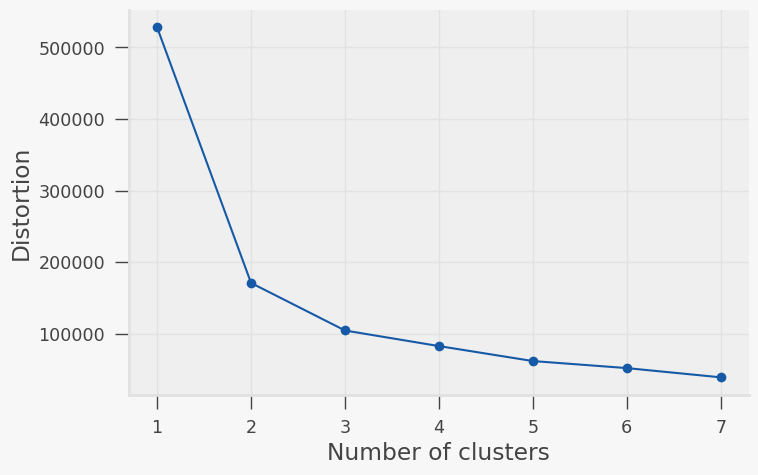

In [19]:
# plot
plt.figure(figsize=(8,5))
plt.plot(range(1, 8), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Podemos observar que el 'codo' representa un punto de inflexión y se genera en la tercera iteración, por lo tanto, k=3 es el parámetro que definirá el número de agrupaciones que estaremos definiendo en el algoritmo de K-means para generar las agrupaciones (clústers) de datos. 

 ## Latitudes y Longitudes de los Almacenes

### Generación de los clústers (agrupaciones)

In [20]:
# Creación de los clústers
k = 3
kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
y_pred = kmeans.predict(X)
y_pred

array([0, 0, 0, ..., 2, 0, 2])

### Localización de los Almacenes (Latitud y Longitud)

In [21]:
# Obtención de los centroides
centroids = kmeans.cluster_centers_
print(centroids)

[[ -93.3271723    37.98006261]
 [ -78.56990807   37.789554  ]
 [-118.62447332   37.48734203]]


### Ciudad en la que se encontrarían los Almacenes

En la siguiente gráfica podemos observar los clústers (agrupaciones) generados por el algoritmo K-means y la localización de los almacenes indicado por el símbolo 'X'.

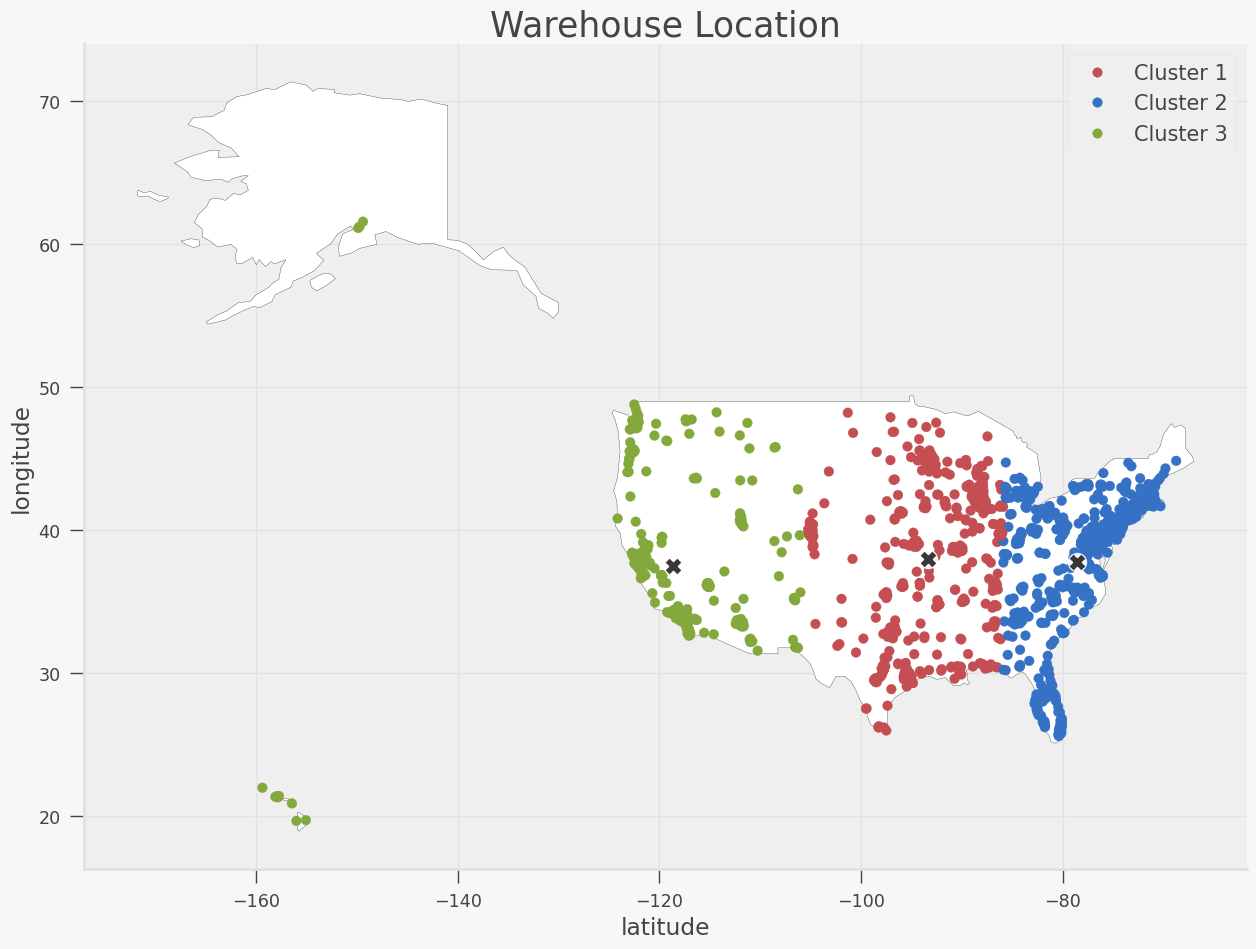

In [22]:
plot_map(X, y_pred, k, centroids)

Determinación de la localización de los almacenes a través de las coordenadas de latitud y longitud representadas por los centroides obtenidos del algoritmo K-means

In [23]:
# Inicialización de la API Nominatim y locación de los almacenes]
geolocator = Nominatim(user_agent="geoapiExercises")

i = 1
warehouse_location = []
for centroid in centroids:
    latitude = round(centroid[1], 6)
    longitude = round(centroid[0], 6)
    location = geolocator.reverse(f"{latitude}, {longitude}")
    warehouse_location.append(location)
    print(f"Localicación del almacén {i} en {location}")
    i += 1 

Localicación del almacén 1 en Hickory County, Missouri, United States
Localicación del almacén 2 en Langhorne Road, Totier Hills, Albemarle County, Virginia, 22946, United States
Localicación del almacén 3 en Paradise Estates, Mono County, California, United States


In [24]:
warehouses = {
    'State' : ['Missouri', 'Virginia', 'California'],
    'Latitude' : [centroids[0][1],
                  centroids[1][1],
                  centroids[2][1]],
    'Longitude' : [centroids[0][0],
                  centroids[1][0],
                  centroids[2][0]]
}

warehouses_df = pd.DataFrame(warehouses)
warehouses_df

,State,Latitude,Longitude
0,Missouri,37.980063,-93.327172
1,Virginia,37.789554,-78.569908
2,California,37.487342,-118.624473


Por lo tanto los almacenes quedarían localizados en los siguientes estados de Estados Unidos en las siguientes localizaciones:
- Missouri
- Virginia
- California

### Distancia entre los Almacenes (Matriz de Distancias entre Centroides)

In [25]:
# Missouri a Virginia
distance_M_to_V = GD((warehouses['Latitude'][0],warehouses['Longitude'][0]),
   (warehouses['Latitude'][1],warehouses['Longitude'][1])).km

# Missouri a California
distance_M_to_C = GD((warehouses['Latitude'][0],warehouses['Longitude'][0]),
   (warehouses['Latitude'][2],warehouses['Longitude'][2])).km

# Virginia a California
distance_V_to_C = GD((warehouses['Latitude'][1],warehouses['Longitude'][1]),
   (warehouses['Latitude'][2],warehouses['Longitude'][2])).km

warehouses_distances = {
    'Distance' : ['Missouri', 'Virginia', 'California'],
    'Missouri' : [0, distance_M_to_V, distance_M_to_C],
    'Virginia' : [0, 0, distance_V_to_C],
    'California' : [0, 0, 0]
}

In [26]:
warehouses_distances_df = pd.DataFrame(warehouses_distances)
print('Matriz de Distancia entre Almacenes \n')
print(warehouses_distances_df.to_string(index=False))

Matriz de Distancia entre Almacenes 

  Distance    Missouri    Virginia  California
  Missouri    0.000000    0.000000           0
  Virginia 1297.004041    0.000000           0
California 2223.726700 3507.813811           0


 ## Anexo

Determinamos importante agregar que en el caso hipotético de que el cliente quisiera incrementar el número de clústers, ya sea por alguna consideración de tener más almacenes en puntos intermedios u otra, es posible, a continuación se muestra un ejemplo aumentando el número de 'k' a cinco.

In [27]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
y_pred = kmeans.predict(X)
y_pred

array([3, 3, 3, ..., 4, 4, 1])

In [28]:
centroids = kmeans.cluster_centers_
print(centroids)

[[ -75.58507975   40.34365502]
 [-119.17634307   37.57977424]
 [ -88.35497835   41.7596358 ]
 [ -82.93309211   31.10391163]
 [ -98.26633716   34.42035677]]


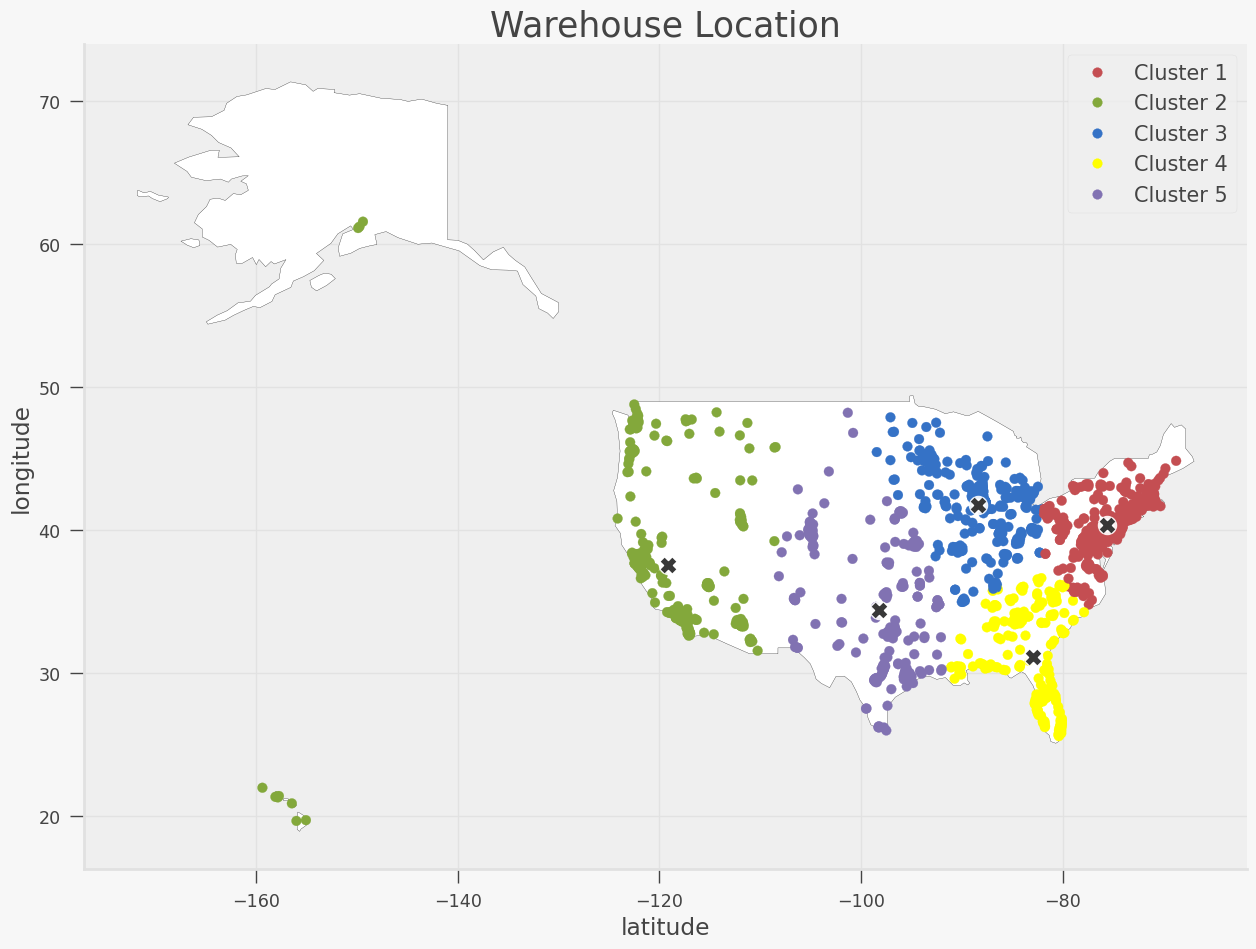

In [29]:
plot_map(X, y_pred, k, centroids)

## Preguntas de la Actividad

- ¿Qué librerías nos pueden ayudar a graficar este tipo de datos?
- ¿Consideras importante que se grafique en un mapa?, ¿por qué?

## Conclusiones